In [1]:
# import gdown
# file_id = '17_boNLEhV6G0jwANXgjm6FClGLoMYmYI'
# output = 'blob'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

In [2]:
# import zipfile
# zip_file_path = "blob"
# extract_to_directory = "extracted_files"
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_directory)
# print("Extraction complete.")

In [3]:
import time

def loading_time_calculator(dataloader):
    t1 = time.time()
    for data in dataloader:
        pass
    t2 = time.time()
    return t2 - t1

In [4]:
import csv
import numpy as np

class CustomDataset:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))
                dataset.append((image, label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

csv_train_path = 'extracted_files/mnist_train.csv'
csv_test_path = 'extracted_files/mnist_test.csv'
custom_dataset = CustomDataset(csv_train_path)
test_data_custom = CustomDataset(csv_test_path)

In [5]:
# Splitting the train dataset into train and validation datasets

from sklearn.model_selection import train_test_split
train_data_custom, val_data_custom = train_test_split(custom_dataset, test_size=0.1, random_state=42)


In [6]:
print("Total length of training set in csv file:",len(custom_dataset))

print("Length of training set after splitting:",len(train_data_custom))
print("Length of validation set after splitting:",len(val_data_custom))
print("Total length of test set in csv file:",len(test_data_custom))

# Access a sample from the dataset
sample_image, sample_label = custom_dataset[0]
print(f"Label: {sample_label}, Image Shape: {sample_image.shape}")

Total length of training set in csv file: 60000
Length of training set after splitting: 54000
Length of validation set after splitting: 6000
Total length of test set in csv file: 10000
Label: 5, Image Shape: (28, 28)


Now we will construct the custom dataloader from scratch

In [7]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indices]

        self.current_index += self.batch_size

        images, labels = zip(*batch_data)
        return np.array(images), np.array(labels)


In [8]:
batch_sizes = [128, 256, 512, 1024]

In [9]:
# Getting loading times for Scratch Implementation for all batch sizes

custom_time=[]
for i in batch_sizes:
    custom_dataloader = CustomDataLoader(custom_dataset, i)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

Now we will do the Pytorch Implementation

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TorchDataset(Dataset):
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))  # Assuming MNIST image dimensions are 28x28
                dataset.append((torch.tensor(image, dtype=torch.float32), label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        # Add channel dimension as torchvision expects (C, H, W)
        image = image.unsqueeze(0)
        return image, label

# Example usage
csv_file_path = 'extracted_files/mnist_train.csv'
torch_dataset = TorchDataset(csv_file_path)

transform = transforms.Compose([
    transforms.ToTensor()
])


In [11]:
# Getting loading times for Pytorch Implementation for all batch sizes

torch_time = []
for i in batch_sizes:
    torch_dataloader = DataLoader(dataset=torch_dataset, batch_size=i, shuffle=True)
    duration = loading_time_calculator(torch_dataloader)
    print(duration)
    torch_time.append(duration)

0.32915711402893066
0.2782280445098877
0.2814328670501709
0.28145456314086914


In [12]:
print("Loading Times obtained for Pytorch Implementation: ",torch_time)
print("Loading Times obtained for Scratch Implementation: ",custom_time)

Loading Times obtained for Pytorch Implementation:  [0.32915711402893066, 0.2782280445098877, 0.2814328670501709, 0.28145456314086914]
Loading Times obtained for Scratch Implementation:  [0.09784221649169922, 0.12563347816467285, 0.09366488456726074, 0.09375119209289551]


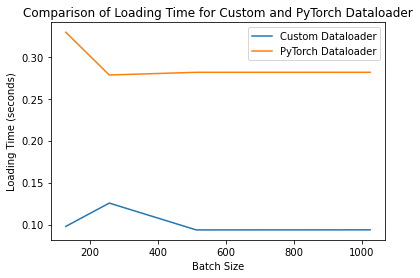

In [13]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

We can see from the above graphs that the Custom Dataloader takes less loading time than pytorch implementation. So for the next steps, we will choose the Custom dataset and dataloader having Batch Size- 512

Now we will Implement the Feed forward Neural Network using Pytorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = FeedForwardNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)
num_epochs = 60

In [15]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

Training the network and getting training, validation and test loss and accuracy

In [16]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)
    

Epoch [1/60], Loss: 1.9572837352752686
Epoch 0, Accuracy on Training Set: 0.176

Epoch [1/60], Validation Loss: 1.9717326164245605
Epoch 0, Accuracy on Validation Set: 0.28833333333333333

Epoch [1/60], Test Loss: 2.0490736961364746
Epoch 0, Accuracy on Test Set: 0.2928
Epoch [2/60], Loss: 1.536946177482605
Epoch 1, Accuracy on Training Set: 0.4069259259259259

Epoch [2/60], Validation Loss: 1.6074601411819458
Epoch 1, Accuracy on Validation Set: 0.513

Epoch [2/60], Test Loss: 1.548313021659851
Epoch 1, Accuracy on Test Set: 0.5178
Epoch [3/60], Loss: 1.2250746488571167
Epoch 2, Accuracy on Training Set: 0.5742962962962963

Epoch [3/60], Validation Loss: 1.249517798423767
Epoch 2, Accuracy on Validation Set: 0.6256666666666667

Epoch [3/60], Test Loss: 1.2541089057922363
Epoch 2, Accuracy on Test Set: 0.6387
Epoch [4/60], Loss: 0.9749524593353271
Epoch 3, Accuracy on Training Set: 0.6601296296296296

Epoch [4/60], Validation Loss: 1.0166720151901245
Epoch 3, Accuracy on Validation Set

Plotting the training vs validation vs test loss

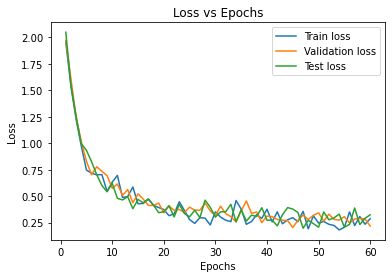

In [17]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Plotting the training vs validation vs test accuracy

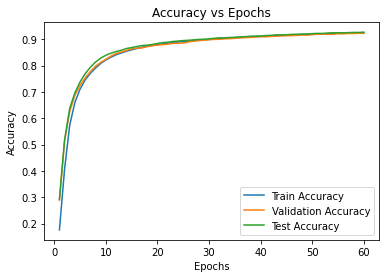

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now I will change the Activation function from Relu to Sigmoid

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x

model = FeedForwardNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)
num_epochs = 60

In [20]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

In [21]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)

Epoch [1/60], Loss: 2.3262434005737305
Epoch 0, Accuracy on Training Set: 0.09974074074074074

Epoch [1/60], Validation Loss: 2.3316049575805664
Epoch 0, Accuracy on Validation Set: 0.09533333333333334

Epoch [1/60], Test Loss: 2.3172225952148438
Epoch 0, Accuracy on Test Set: 0.1032
Epoch [2/60], Loss: 2.30328369140625
Epoch 1, Accuracy on Training Set: 0.09974074074074074

Epoch [2/60], Validation Loss: 2.3255317211151123
Epoch 1, Accuracy on Validation Set: 0.09533333333333334

Epoch [2/60], Test Loss: 2.329099655151367
Epoch 1, Accuracy on Test Set: 0.1032
Epoch [3/60], Loss: 2.3263437747955322
Epoch 2, Accuracy on Training Set: 0.09974074074074074

Epoch [3/60], Validation Loss: 2.3319737911224365
Epoch 2, Accuracy on Validation Set: 0.09533333333333334

Epoch [3/60], Test Loss: 2.317148208618164
Epoch 2, Accuracy on Test Set: 0.1032
Epoch [4/60], Loss: 2.2939913272857666
Epoch 3, Accuracy on Training Set: 0.09974074074074074

Epoch [4/60], Validation Loss: 2.3125739097595215
Epoc

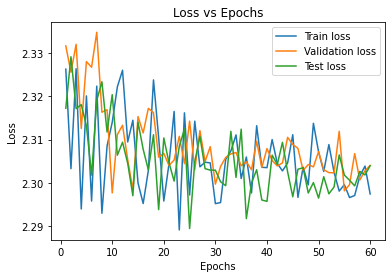

In [22]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

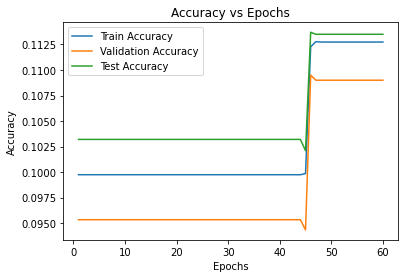

In [23]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now we will construct the Feed forward Neural Network from Scratch.

In [24]:
import numpy as np

class CustomFeedForwardNN:
    def __init__(self):
        self.weights = {
            'fc1': np.random.randn(28 * 28, 32),
            'fc2': np.random.randn(32, 32),
            'fc3': np.random.randn(32, 32),
            'fc4': np.random.randn(32, 32),
            'fc5': np.random.randn(32, 10)
        }

        self.biases = {
            'fc1': np.zeros((1, 32)),
            'fc2': np.zeros((1, 32)),
            'fc3': np.zeros((1, 32)),
            'fc4': np.zeros((1, 32)),
            'fc5': np.zeros((1, 10))
        }

        self.layer_outputs = {}

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        self.layer_outputs['fc0'] = x
        x = self.relu(np.dot(x, self.weights['fc1']) + self.biases['fc1'])
        self.layer_outputs['fc1'] = x
        x = self.relu(np.dot(x, self.weights['fc2']) + self.biases['fc2'])
        self.layer_outputs['fc2'] = x
        x = self.relu(np.dot(x, self.weights['fc3']) + self.biases['fc3'])
        self.layer_outputs['fc3'] = x
        x = self.relu(np.dot(x, self.weights['fc4']) + self.biases['fc4'])
        self.layer_outputs['fc4'] = x
        x = np.dot(x, self.weights['fc5']) + self.biases['fc5']
        self.layer_outputs['fc5'] = x
        return x

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, y_true, learning_rate):
        m = x.shape[0]

        # Calculate loss
        loss = self.cross_entropy_loss(self.softmax(self.layer_outputs['fc5']), y_true)

        # Backpropagation
        d_fc5 = self.softmax(self.layer_outputs['fc5'])
        d_fc5[range(m), y_true.argmax(axis=1)] -= 1
        d_fc5 /= m

        d_fc4 = np.dot(d_fc5, self.weights['fc5'].T)
        d_fc4[self.layer_outputs['fc4'] <= 0] = 0

        d_fc3 = np.dot(d_fc4, self.weights['fc4'].T)
        d_fc3[self.layer_outputs['fc3'] <= 0] = 0

        d_fc2 = np.dot(d_fc3, self.weights['fc3'].T)
        d_fc2[self.layer_outputs['fc2'] <= 0] = 0

        d_fc1 = np.dot(d_fc2, self.weights['fc2'].T)
        d_fc1[self.layer_outputs['fc1'] <= 0] = 0

        # Update weights and biases
        self.weights['fc5'] -= learning_rate * np.dot(self.layer_outputs['fc4'].T, d_fc5)
        self.biases['fc5'] -= learning_rate * np.sum(d_fc5, axis=0, keepdims=True)

        self.weights['fc4'] -= learning_rate * np.dot(self.layer_outputs['fc3'].T, d_fc4)
        self.biases['fc4'] -= learning_rate * np.sum(d_fc4, axis=0, keepdims=True)

        self.weights['fc3'] -= learning_rate * np.dot(self.layer_outputs['fc2'].T, d_fc3)
        self.biases['fc3'] -= learning_rate * np.sum(d_fc3, axis=0, keepdims=True)

        self.weights['fc2'] -= learning_rate * np.dot(self.layer_outputs['fc1'].T, d_fc2)
        self.biases['fc2'] -= learning_rate * np.sum(d_fc2, axis=0, keepdims=True)

        self.weights['fc1'] -= learning_rate * np.dot(self.layer_outputs['fc0'].T, d_fc1)
        self.biases['fc1'] -= learning_rate * np.sum(d_fc1, axis=0, keepdims=True)

        return loss

In [25]:
# Start from here. The class above should be correct. So try to work it without getting into it.

custom_model = CustomFeedForwardNN()

for epoch in range(60):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        # print(type(inputs))
        # print(type(labels))
        # print(inputs.shape)
        # labels = np.eye(10)[labels]
        # inputs = torch.from_numpy(inputs).float()
        # labels = torch.from_numpy(labels).long()
        # optimizer.zero_grad()
        outputs = custom_model.forward(inputs)
        one_labels = np.eye(10)[labels]
        # print(labels.shape)
        loss = custom_model.backward(inputs, one_labels, 0.0003)
        # print("coll")
        # print(np.argmax(custom_model.softmax(outputs), axis=1))
        # print("loll")
        # print(labels)
        # print("boll")
        acc = np.mean(np.argmax(custom_model.softmax(outputs), axis=1) == labels)
        print("Accuracy:",acc)
        # optimizer.step()
        # _, predicted = torch.max(outputs, 1)
        # total_correct += (predicted == labels).sum().item()
        # total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    # train_loss_list.append(loss.item())
    # accuracy = total_correct / total_samples
    # print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    # train_accuracy_list.append(accuracy)
    # print(accuracy)

C:\Users\Shivansh\AppData\Local\Temp/ipykernel_10436/915185048.py:47: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])


Accuracy: 0.125
Accuracy: 0.099609375
Accuracy: 0.12109375
Accuracy: 0.076171875
Accuracy: 0.107421875
Accuracy: 0.1328125
Accuracy: 0.11328125
Accuracy: 0.099609375
Accuracy: 0.095703125
Accuracy: 0.08203125
Accuracy: 0.09375
Accuracy: 0.111328125
Accuracy: 0.1171875
Accuracy: 0.095703125
Accuracy: 0.09375
Accuracy: 0.0859375
Accuracy: 0.095703125
Accuracy: 0.099609375
Accuracy: 0.10546875
Accuracy: 0.080078125
Accuracy: 0.099609375
Accuracy: 0.091796875
Accuracy: 0.091796875
Accuracy: 0.1015625
Accuracy: 0.119140625
Accuracy: 0.078125
Accuracy: 0.09765625
Accuracy: 0.10546875
Accuracy: 0.123046875
Accuracy: 0.08984375
Accuracy: 0.076171875
Accuracy: 0.10546875
Accuracy: 0.10546875
Accuracy: 0.09375
Accuracy: 0.1328125
Accuracy: 0.125
Accuracy: 0.099609375
Accuracy: 0.1015625
Accuracy: 0.095703125
Accuracy: 0.087890625
Accuracy: 0.091796875
Accuracy: 0.10546875
Accuracy: 0.091796875
Accuracy: 0.083984375
Accuracy: 0.11328125
Accuracy: 0.095703125
Accuracy: 0.107421875
Accuracy: 0.1093

In [26]:
# Dummy input data and labels
input_data = np.random.randn(100, 28, 28)
labels = np.random.randint(0, 10, size=(100,))

print(type(input_data))
print(type(labels))
print(input_data.shape)
# One-hot encode the labels
one_hot_labels = np.eye(10)[labels]
print(one_hot_labels.shape)
print(type(labels))
# Create the model
custom_model = CustomFeedForwardNN()

# Training loop
num_epochs = 1000
learning_rate = 0.001

for epoch in range(num_epochs):
    # Forward pass
    output = custom_model.forward(input_data)

    # Backward pass and optimization
    loss = custom_model.backward(input_data, one_hot_labels, learning_rate)
    acc = np.mean(np.argmax(custom_model.softmax(output), axis=1) == labels)

    print("accuracy: ", acc)
    # Print loss for every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss}')

# Test the trained model on new data
test_data = np.random.randn(10, 28, 28)
predictions = custom_model.forward(test_data)
print(predictions.argmax(axis=1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(100, 28, 28)
(100, 10)
<class 'numpy.ndarray'>
accuracy:  0.1
Epoch [0/1000], Loss: inf
accuracy:  0.15
accuracy:  0.12
accuracy:  0.16
accuracy:  0.22
accuracy:  0.26
accuracy:  0.34
accuracy:  0.44
accuracy:  0.49
accuracy:  0.49
accuracy:  0.53
accuracy:  0.59
accuracy:  0.66
accuracy:  0.67
accuracy:  0.7
accuracy:  0.68
accuracy:  0.69
accuracy:  0.75
accuracy:  0.77
accuracy:  0.79
accuracy:  0.82
accuracy:  0.82
accuracy:  0.8
accuracy:  0.85
accuracy:  0.86
accuracy:  0.83
accuracy:  0.89
accuracy:  0.87
accuracy:  0.85
accuracy:  0.85
accuracy:  0.87
accuracy:  0.9
accuracy:  0.91
accuracy:  0.87
accuracy:  0.91
accuracy:  0.91
accuracy:  0.91
accuracy:  0.89
accuracy:  0.91
accuracy:  0.88
accuracy:  0.88
accuracy:  0.86
accuracy:  0.89
accuracy:  0.89
accuracy:  0.88
accuracy:  0.89
accuracy:  0.9
accuracy:  0.86
accuracy:  0.9
accuracy:  0.92
accuracy:  0.92
accuracy:  0.9
accuracy:  0.91
accuracy:  0.9
accuracy:  0.88
accura

C:\Users\Shivansh\AppData\Local\Temp/ipykernel_10436/915185048.py:47: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])


accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
Epoch [200/1000], Loss: 0.16028290210657256
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0.96
accuracy:  0